# EV Charging Infrastructure Demand Analysis

This notebook analyzes demand patterns and generates location recommendations based on:
1. Previously collected charging station and potential location data
2. Population density from Statistics Canada
3. Coverage and accessibility metrics

## Key Objectives:
- Analyze population coverage of existing infrastructure
- Identify high-demand areas
- Score potential locations for new stations
- Generate recommendations for optimization model

In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from pathlib import Path
from datetime import datetime
import tqdm

from src.data.api_client import APIClient
from src.data.constants import *
from src.data.utils import *
from src.visualization import map_viz

# Initialize API client (only needed for population data)
client = APIClient()

## 1. Load and Prepare Data
Load our previously processed location data and fetch population density information.

In [2]:
# Get latest processed location data
analyzed_locations_file, al_timestamp = get_latest_csv(DATA_PATHS['analyzed_locations'])
print(f"Loading previously analyzed location data from {al_timestamp}")
print(f"File: {analyzed_locations_file}")
analyzed_population_df = pd.read_csv(analyzed_locations_file)
analyzed_population_df.head()

Loading previously analyzed location data from 2024-11-13 02:14:44
File: /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/analyzed_locations/analyzed_locations_2024-11-13_02-14-44.csv


name   latitude  longitude  num_chargers  \
0            Metropolitan Towers  43.460806 -80.512639           1.0   
1                WATERLOO REGION  43.463730 -80.519593           1.0   
2                 William Street  43.463168 -80.519858           1.0   
3  Christian Horizon - North Lot  43.467422 -80.518764           1.0   
4               Bridgeport Plaza  43.470145 -80.515211           1.0   

  charger_type                   operator                  address      city  \
0      Level 2  SWTCH - Charge Everywhere            57 Union St E  Waterloo   
1      Level 2                ChargePoint  100 Regina Street South  Waterloo   
2      Level 2                        flo   29 William Street East  Waterloo   
3      Level 2                        flo            26 Peppler St  Waterloo   
4      Level 2  SWTCH - Charge Everywhere       70 Bridgeport Rd E  Waterloo   

  postal_code usage_cost    data_source     location_type  area geometry_type  \
0     N2J 1C1    Unknown  OpenChargeMap  charging_station   NaN           NaN   
1     N2J 4A8    Unknown  OpenChargeMap  charging_station   NaN           NaN   
2     N2L 1J4    Unknown  OpenChargeMap  charging_station   NaN           NaN   
3     N2J 3C4    Unknown  OpenChargeMap  charging_station   NaN           NaN   
4     N2J 2J9    Unknown  OpenChargeMap  charging_station   NaN           NaN   

   min_distance_to_station  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0

In [3]:
# Initialize API client and fetch population data
client = APIClient()
population_df = client.fetch_population_density()

# Save population data
pd_timestamp = grab_time()
population_file = DATA_PATHS['population_density'] / f'population_density_{pd_timestamp}.csv'
population_df.to_csv(population_file, index=False)
print(f"Population data saved to: {population_file}")

Fetching population density data from OpenStreetMap...

📊 Data Collection Summary
Generated: November 13, 2024 at 05:47:30

📍 Data Sources and Versions:
• OpenStreetMap (OSM):
  - OSMnx Version: 1.9.4
  - PyProj Version: 3.7.0

🏘️ Processing cities...

📍 Processing Kitchener...
   Fetching residential buildings...
   ✓ Found 9,102 buildings
   Processing building data...


100%|██████████████████████████████| 9102/9102 [00:00<00:00, 24051.45it/s]



   Fetching amenities...
   ✓ Found 91 amenities
   Processing amenity data...


100%|██████████████████████████████| 91/91 [00:00<00:00, 19730.25it/s]



📍 Processing Waterloo...
   Fetching residential buildings...
   ✓ Found 7,896 buildings
   Processing building data...


100%|██████████████████████████████| 7896/7896 [00:00<00:00, 24190.80it/s]



   Fetching amenities...
   ✓ Found 43 amenities
   Processing amenity data...


100%|██████████████████████████████| 43/43 [00:00<00:00, 16391.45it/s]



Features Found:
  - Total Features: 17,132
    ∟ 16,998 residential buildings
    ∟ 134 public amenities

📊 Regional Summary by City:

Kitchener:
  Residential:
    • Buildings: 9,102
    • Est. Population: 383,473
    • Total Area: 1.90 km²
  Amenities:
    • Locations: 91
    • Daily Population: 235,500
    • Total Area: 7.06 km²

Waterloo:
  Residential:
    • Buildings: 7,896
    • Est. Population: 245,756
    • Total Area: 1.54 km²
  Amenities:
    • Locations: 43
    • Daily Population: 143,500
    • Total Area: 5.66 km²
Population data saved to: /u1/a9dutta/co370/kw-ev-charging-optimization/data/raw/population_density/population_density_2024-11-13_05-47-32.csv


In [4]:
# Updated Data Summary
print("\nData Summary:")
print(f"Total locations: {len(analyzed_population_df)}")
print(f"- Existing stations: {len(analyzed_population_df[analyzed_population_df['data_source'] == 'OpenChargeMap'])}")
print(f"- Potential locations: {len(analyzed_population_df[analyzed_population_df['data_source'] == 'OpenStreetMap'])}")
print(f"Population density points: {len(population_df)}")

print("\nData Timestamps:")
print(f"Population Data: {pd_timestamp}")
print(f"Analyzed Locations Data: {al_timestamp}")


Data Summary:
Total locations: 3683
- Existing stations: 132
- Potential locations: 3551
Population density points: 17132

Data Timestamps:
Population Data: 2024-11-13_05-47-32
Analyzed Locations Data: 2024-11-13 02:14:44


In [5]:
def create_population_map(population_df, title="Population Density"):
    """Create a map with population heatmap."""
    m = map_viz.create_kw_map()
    
    # Create locations list and convert weights to Python list
    locations = [[row['latitude'], row['longitude']] 
                for _, row in population_df.iterrows()]
    weights = population_df['population'].values.tolist()  # Convert numpy array to list
    
    folium.plugins.HeatMap(
        locations,
        weights=weights,
        radius=15,
        blur=20,
        max_zoom=13,
        name=title
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Create summary statistics
print("Population Statistics:")
total_pop = population_df['population'].sum()
print(f"Total Population: {total_pop:,.0f}")

# Create separate maps for different population types
print("\nGenerating population density maps...")

# 1. Overall population
print("\nOverall Population Distribution:")
m_all = create_population_map(population_df, "All Population")
display(m_all)

# 2. Residential population
residential_mask = population_df['location_type'] == 'residential'
residential_df = population_df[residential_mask]
residential_pop = residential_df['population'].sum()
print(f"\nResidential Population: {residential_pop:,.0f} ({residential_pop/total_pop:.1%} of total)")
m_residential = create_population_map(residential_df, "Residential Population")
display(m_residential)

# 3. Amenity population
amenity_mask = population_df['location_type'] == 'amenity'
amenity_df = population_df[amenity_mask]
amenity_pop = amenity_df['population'].sum()
print(f"\nAmenity Daily Population: {amenity_pop:,.0f} ({amenity_pop/total_pop:.1%} of total)")

# Show amenity breakdown
print("\nAmenity Breakdown:")
amenity_stats = (amenity_df.groupby('amenity_type')
                .agg({
                    'population': ['count', 'sum', 'mean']
                })
                .round(2))
print(amenity_stats)

m_amenity = create_population_map(amenity_df, "Amenity Population")
display(m_amenity)

Population Statistics:
Total Population: 1,008,229

Generating population density maps...

Overall Population Distribution:



Residential Population: 629,229 (62.4% of total)



Amenity Daily Population: 379,000 (37.6% of total)

Amenity Breakdown:
             population                    
                  count       sum      mean
amenity_type                               
college               4   75500.0  18875.00
school              123  123000.0   1000.00
university            7  180500.0  25785.71


In [6]:
# Save processed population data
print("\nSaving processed population data...")
output_file = DATA_PATHS['population_analysis'] / f'population_analysis_{grab_time()}.csv'
population_df.to_csv(output_file, index=False)
print(f"Saved to: {output_file}")


Saving processed population data...
Saved to: /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/population_analysis/population_analysis_2024-11-13_05-47-33.csv


## 2. Current Coverage Analysis
Let's analyze how well the existing charging stations cover the population:

In [7]:
def calculate_coverage_metrics(points_df, population_df, radius_km=2):
    """Calculate population coverage within radius of points."""
    covered_population = 0
    total_population = population_df['population'].sum()
    
    # Convert coordinates to numpy arrays for efficient calculation
    point_coords = np.column_stack((
        points_df['longitude'].values,
        points_df['latitude'].values
    ))
    pop_coords = np.column_stack((
        population_df['longitude'].values,
        population_df['latitude'].values
    ))
    
    # Calculate coverage using numpy operations
    for i, pop_point in enumerate(pop_coords):
        # Calculate distances using vectorized operations
        distances = np.sqrt(
            ((point_coords - pop_point) ** 2).sum(axis=1)
        ) * 111  # Convert to km
        
        if (distances <= radius_km).any():
            covered_population += population_df.iloc[i]['population']
    
    return {
        'covered_population': covered_population,
        'coverage_percentage': (covered_population / total_population) * 100 if total_population > 0 else 0,
        'total_population': total_population
    }

# Calculate current coverage
residential_mask = population_df['location_type'] == 'residential'
residential_df = population_df[residential_mask]

charging_mask = analyzed_population_df['data_source'] == 'OpenChargeMap'
charging_df = analyzed_population_df[charging_mask]

coverage = calculate_coverage_metrics(charging_df, residential_df)

# Display coverage statistics
print("Current Coverage Analysis:")
print("-" * 50)
print(f"Total Population: {coverage['total_population']:,.0f}")
print(f"Population Covered: {coverage['covered_population']:,.0f}")
print(f"Coverage Percentage: {coverage['coverage_percentage']:.1f}%")

Current Coverage Analysis:
--------------------------------------------------
Total Population: 629,229
Population Covered: 597,606
Coverage Percentage: 95.0%


In [8]:
# Check the unique values in the charger_type column
print(charging_df['charger_type'].unique())

# Visualize coverage
plt.figure(figsize=(12, 8))
m = map_viz.create_kw_map()

# Add population density heatmap
locations = [[row['latitude'], row['longitude']] 
            for _, row in residential_df.iterrows()]
weights = residential_df['population'].tolist()  # Convert to list

folium.plugins.HeatMap(
    locations,
    weights=weights,
    radius=15,
    blur=20,
    max_zoom=13
).add_to(m)

# Add existing charging stations using map_viz function
map_viz.plot_charging_stations(m, charging_df)

m

['Level 2' 'Level 3']


<Figure size 1200x800 with 0 Axes>

## 3. Identify Underserved Areas
Let's find areas with high population density but low charging station coverage:

In [9]:
def calculate_service_score(row, charging_df, radius_km=2):
    """Calculate how well an area is served by existing stations using vectorized operations."""
    # Get coordinates as numpy arrays
    station_coords = np.column_stack((
        charging_df['longitude'].values,
        charging_df['latitude'].values
    ))
    point_coord = np.array([row['longitude'], row['latitude']])
    
    # Calculate distances using vectorized operations
    distances = np.sqrt(
        ((station_coords - point_coord) ** 2).sum(axis=1)
    ) * 111  # Convert to km
    
    if len(distances) == 0:
        return 0.0
    
    # Calculate service score based on distance and number of nearby stations
    nearby_stations = (distances <= radius_km).sum()
    min_distance = distances.min()
    
    if nearby_stations == 0:
        return 0.0
    else:
        return float(nearby_stations * (1 - min_distance/radius_km))

# Calculate service scores
print("Calculating service scores...")
print("Note: This might take a minute.")
print("-" * 50)
residential_df = residential_df.copy()
residential_df.loc[:, 'service_score'] = residential_df.apply(
    lambda row: calculate_service_score(row, charging_df),
    axis=1
)

# Identify underserved areas
residential_df.loc[:, 'demand_score'] = (
    residential_df['population'] * 
    (1 - residential_df['service_score'].clip(0, 1))
)

# Display top underserved areas
print("\nTop 10 Underserved Areas:")
print("-" * 50)
top_underserved = residential_df.nlargest(10, 'demand_score')
for idx, area in enumerate(top_underserved.itertuples(), start=1):
    print(f"#{idx:02d} Location: ({area.latitude:.4f}, {area.longitude:.4f})")
    print(f"    Population: {area.population:,.0f}")
    print(f"    Service Score: {area.service_score:.2f}")
    print(f"    Demand Score: {area.demand_score:.2f}")
    print("-" * 60)

Calculating service scores...
Note: This might take a minute.
--------------------------------------------------

Top 10 Underserved Areas:
--------------------------------------------------
#01 Location: (43.4068, -80.5179)
    Population: 236
    Service Score: 0.00
    Demand Score: 235.73
------------------------------------------------------------
#02 Location: (43.4236, -80.5519)
    Population: 236
    Service Score: 0.10
    Demand Score: 211.52
------------------------------------------------------------
#03 Location: (43.4241, -80.5522)
    Population: 236
    Service Score: 0.13
    Demand Score: 203.99
------------------------------------------------------------
#04 Location: (43.4707, -80.5918)
    Population: 181
    Service Score: 0.00
    Demand Score: 181.16
------------------------------------------------------------
#05 Location: (43.4708, -80.5982)
    Population: 181
    Service Score: 0.00
    Demand Score: 181.16
--------------------------------------------------

In [14]:
# Visualize underserved areas
plt.figure(figsize=(12, 8))
m2 = map_viz.create_kw_map()

# Add existing stations
map_viz.plot_charging_stations(m2, charging_df)

# Add top underserved areas
for _, area in top_underserved.iterrows():
    folium.CircleMarker(
        location=[area['latitude'], area['longitude']],
        radius=8,
        color='orange',
        fill=True,
        popup=f"Population: {area['population']:,.0f}<br>Demand Score: {area['demand_score']:.2f}"
    ).add_to(m2)

m2

<Figure size 1200x800 with 0 Axes>

In the above map, the orange markers represent the top 10 underserved areas based on the demand score.

The above analysis provides a good starting point for identifying potential locations for new charging stations.
However, there are several factors that could be considered to further refine the selection process:

## 4. Analyze Potential Locations

Now let's score potential locations based on multiple factors:
- Population coverage
- Distance to existing stations
- Proximity to amenities
- Accessibility

In [25]:
def calculate_location_score(row, residential_df, charging_df, amenities_df):
    """Calculate comprehensive score for potential charging station location."""
    
    # 1. Population Coverage (40%)
    row_df = pd.DataFrame({
        'latitude': [row['latitude']],
        'longitude': [row['longitude']]
    })
    pop_coverage = calculate_coverage_metrics(row_df, residential_df, radius_km=2)
    pop_score = pop_coverage['coverage_percentage'] / 100
    
    # 2. Distance to Existing Stations (30%)
    # Use our optimized service score
    service_score = calculate_service_score(row, charging_df, radius_km=2)
    distance_score = 1 - min(service_score, 1)  # Higher score if further from existing stations
    
    # 3. Amenity Proximity (20%)
    if len(amenities_df) > 0:
        amenity_coords = np.column_stack((
            amenities_df['longitude'].values,
            amenities_df['latitude'].values
        ))
        point_coord = np.array([row['longitude'], row['latitude']])
        
        # Calculate distances using vectorized operations
        amenity_distances = np.sqrt(
            ((amenity_coords - point_coord) ** 2).sum(axis=1)
        ) * 111  # Convert to km
        
        min_amenity_dist = amenity_distances.min()
        amenity_score = 1 - min(min_amenity_dist / 2, 1)  # Scale to 2km
    else:
        amenity_score = 0
    
    # 4. Location Type Score (10%)
    type_scores = {
        'parking': 1.0,
        'fuel': 0.8,
        'retail': 0.7,
        'commercial': 0.6
    }
    location_score = type_scores.get(row['location_type'], 0.5)
    
    # Calculate weighted final score
    final_score = (
        pop_score * 0.4 +
        distance_score * 0.3 +
        amenity_score * 0.2 +
        location_score * 0.1
    )
    
    return {
        'population_score': float(pop_score),
        'distance_score': float(distance_score),
        'amenity_score': float(amenity_score),
        'location_score': float(location_score),
        'final_score': float(final_score)
    }

# Filter potential locations
potential_mask = (
    (population_df['location_type'] != 'charging_station') &
    (population_df['location_type'] != 'residential')
)
potential_locations = population_df[potential_mask].copy()

# Get amenities
amenities_mask = population_df['location_type'] == 'amenity'
amenities_df = population_df[amenities_mask].copy()

print("Data Preparation Summary:")
print(f"Residential areas: {len(residential_df)}")
print(f"Potential locations: {len(potential_locations)}")
print(f"Amenities: {len(amenities_df)}")

# Calculate scores
print("\nCalculating location scores...")
scores = []
for idx, location in tqdm.tqdm(potential_locations.iterrows(), total=len(potential_locations)):
    score_dict = calculate_location_score(
        location,
        residential_df,
        charging_df,
        amenities_df
    )
    scores.append({
        'name': location['name'],
        'latitude': location['latitude'],
        'longitude': location['longitude'],
        'location_type': location['location_type'],
        **score_dict
    })

scores_df = pd.DataFrame(scores)

# Create detailed summary
print("\n📊 Location Scoring Summary")
print("=" * 50)
print(f"Total locations evaluated: {len(scores_df)}")
print("\nScore Distribution:")
for component in ['population_score', 'distance_score', 'amenity_score', 'location_score', 'final_score']:
    print(f"\n{component.replace('_', ' ').title()}:")
    print(f"  • Mean: {scores_df[component].mean():.3f}")
    print(f"  • Median: {scores_df[component].median():.3f}")
    print(f"  • Range: {scores_df[component].min():.3f} - {scores_df[component].max():.3f}")

# Display top locations with detailed breakdown
print("\n🏆 Top 10 Recommended Locations")
print("=" * 50)
top_locations = scores_df.nlargest(10, 'final_score')

for idx, loc in top_locations.iterrows():
    print(f"\n{idx + 1}. {loc['name']}")
    print(f"Location Type: {loc['location_type'].title()}")
    print(f"Coordinates: ({loc['latitude']:.4f}, {loc['longitude']:.4f})")
    print(f"Score Breakdown:")
    print(f"  • Population Coverage: {loc['population_score']:.3f} (40% weight)")
    print(f"  • Distance from Existing: {loc['distance_score']:.3f} (30% weight)")
    print(f"  • Amenity Proximity: {loc['amenity_score']:.3f} (20% weight)")
    print(f"  • Location Type: {loc['location_score']:.3f} (10% weight)")
    print(f"  → Final Score: {loc['final_score']:.3f}")

Data Preparation Summary:
Residential areas: 16998
Potential locations: 134
Amenities: 134

Calculating location scores...


100%|██████████| 134/134 [00:15<00:00,  8.40it/s]


📊 Location Scoring Summary
Total locations evaluated: 134

Score Distribution:

Population Score:
  • Mean: 0.062
  • Median: 0.060
  • Range: 0.000 - 0.189

Distance Score:
  • Mean: 0.198
  • Median: 0.000
  • Range: 0.000 - 1.000

Amenity Score:
  • Mean: 1.000
  • Median: 1.000
  • Range: 1.000 - 1.000

Location Score:
  • Mean: 0.500
  • Median: 0.500
  • Range: 0.500 - 0.500

Final Score:
  • Mean: 0.334
  • Median: 0.290
  • Range: 0.250 - 0.582

🏆 Top 10 Recommended Locations

116. St. Nicholas Catholic Elementary School
Location Type: Amenity
Coordinates: (43.4720, -80.5872)
Score Breakdown:
  • Population Coverage: 0.080 (40% weight)
  • Distance from Existing: 1.000 (30% weight)
  • Amenity Proximity: 1.000 (20% weight)
  • Location Type: 0.500 (10% weight)
  → Final Score: 0.582

118. Laurel Heights Secondary School
Location Type: Amenity
Coordinates: (43.4717, -80.5956)
Score Breakdown:
  • Population Coverage: 0.066 (40% weight)
  • Distance from Existing: 1.000 (30% wei

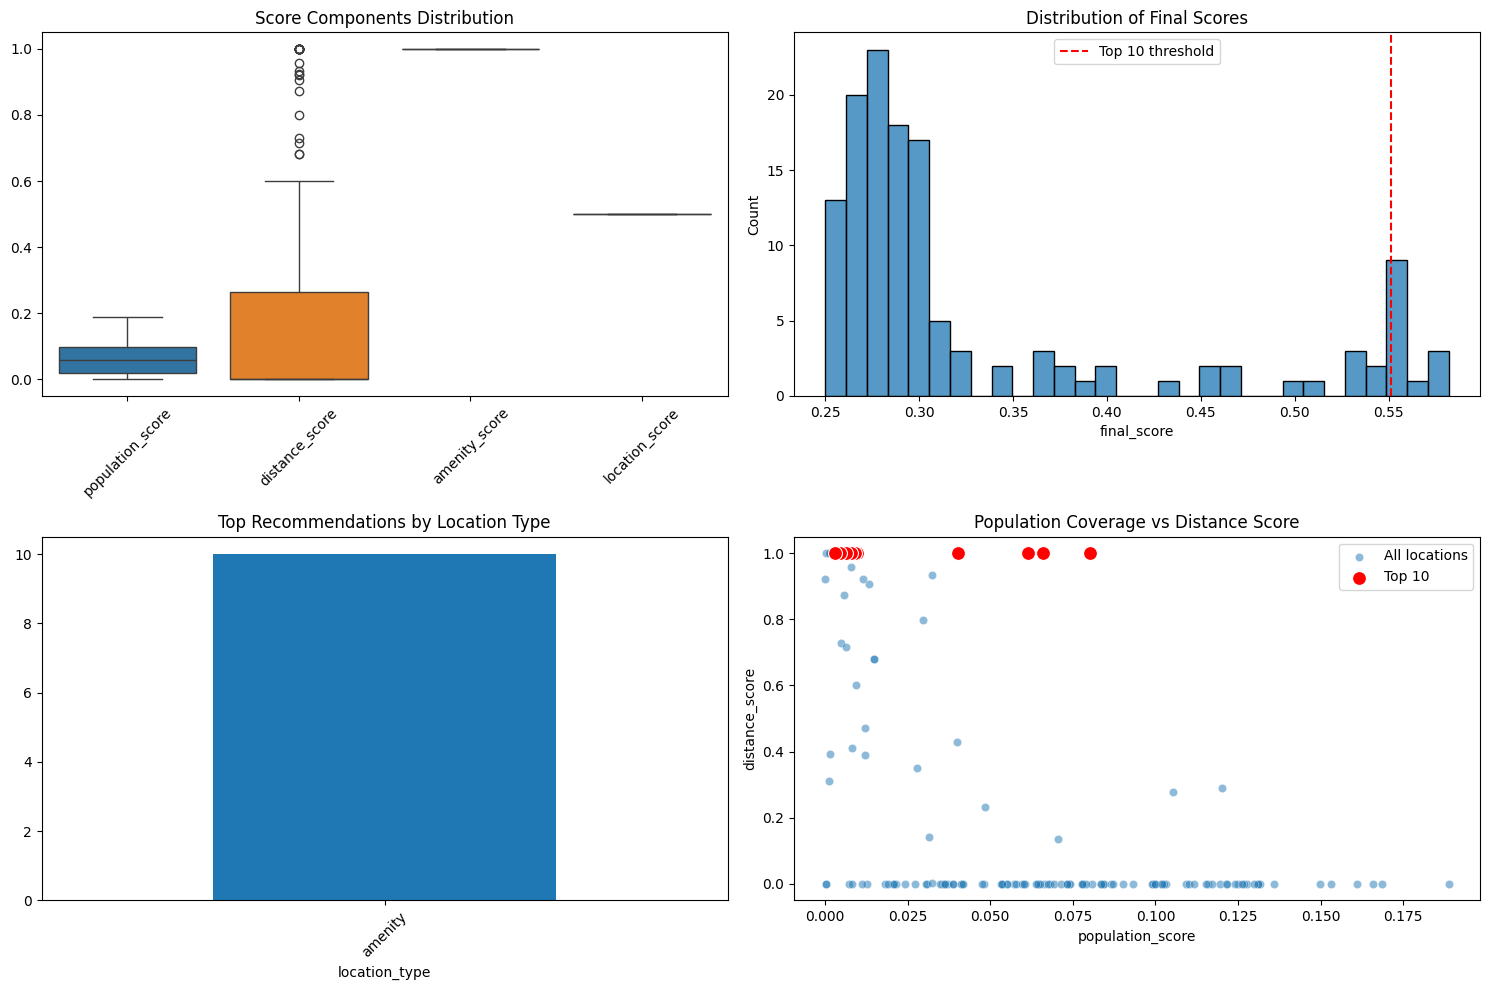

In [26]:
# Create visualization
plt.figure(figsize=(15, 10))

# 1. Score distribution plot
plt.subplot(2, 2, 1)
sns.boxplot(data=scores_df[['population_score', 'distance_score', 
                           'amenity_score', 'location_score']])
plt.xticks(rotation=45)
plt.title('Score Components Distribution')

# 2. Final score histogram
plt.subplot(2, 2, 2)
sns.histplot(data=scores_df, x='final_score', bins=30)
plt.title('Distribution of Final Scores')
plt.axvline(top_locations['final_score'].min(), color='r', 
            linestyle='--', label='Top 10 threshold')
plt.legend()

# 3. Location type breakdown for top recommendations
plt.subplot(2, 2, 3)
top_locations['location_type'].value_counts().plot(kind='bar')
plt.title('Top Recommendations by Location Type')
plt.xticks(rotation=45)

# 4. Scatter plot of population vs distance scores
plt.subplot(2, 2, 4)
sns.scatterplot(data=scores_df, x='population_score', y='distance_score', 
                alpha=0.5, label='All locations')
sns.scatterplot(data=top_locations, x='population_score', y='distance_score',
                color='red', s=100, label='Top 10')
plt.title('Population Coverage vs Distance Score')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Create interactive map
print("\n🗺️ Creating interactive map visualization...")
m4 = map_viz.create_kw_map()

# Add existing charging stations
for _, station in charging_df.iterrows():
    folium.CircleMarker(
        location=[station['latitude'], station['longitude']],
        radius=6,
        color='green',
        fill=True,
        popup=f"Existing Station:<br>{station.get('name', 'Unnamed')}<br>{station['charger_type']}<br>{station['operator']}",        
        tooltip='Existing Station'
    ).add_to(m4)

# Add recommended locations with detailed popups
for idx, loc in top_locations.iterrows():
    popup_html = f"""
    <div style="min-width: 200px">
        <h4>{loc['name']}</h4>
        <b>Rank:</b> {idx + 1}<br>
        <b>Type:</b> {loc['location_type']}<br>
        <b>Final Score:</b> {loc['final_score']:.3f}<br>
        <hr>
        <b>Score Breakdown:</b><br>
        • Population: {loc['population_score']:.3f}<br>
        • Distance: {loc['distance_score']:.3f}<br>
        • Amenity: {loc['amenity_score']:.3f}<br>
        • Location: {loc['location_score']:.3f}
    </div>
    """
    
    folium.CircleMarker(
        location=[loc['latitude'], loc['longitude']],
        radius=8,
        color='blue',
        fill=True,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"Rank {idx + 1}: {loc['name']}"
    ).add_to(m4)

# Add a legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
            padding: 10px; border: 2px solid grey; border-radius: 5px;">
    <h4>Legend</h4>
    <p>
        <span style="color: green;">●</span> Existing Stations<br>
        <span style="color: blue;">●</span> Recommended Locations
    </p>
</div>
"""
m4.get_root().html.add_child(folium.Element(legend_html))

# Display map
m4


🗺️ Creating interactive map visualization...


In [33]:
# Save results
# timestamp = grab_time()
# results_file = PROCESSED_DATA_DIR / f'location_recommendations_{timestamp}.csv'
# scores_df.to_csv(results_file, index=False)
# print(f"\n💾 Results saved to: {results_file}")

print("\n📝 Summary Statistics")
print("=" * 50)
print(f"Total locations analyzed: {len(scores_df)}")
print(f"Median final score: {scores_df['final_score'].median():.3f}")
print(f"Top 10 score range: {top_locations['final_score'].min():.3f} - {top_locations['final_score'].max():.3f}")
print(f"\nTop location types:")
for type_name, count in top_locations['location_type'].value_counts().items():
    print(f"  • {type_name.title()}: {count}")


📝 Summary Statistics
Total locations analyzed: 134
Median final score: 0.290
Top 10 score range: 0.551 - 0.582

Top location types:
  • Amenity: 10


## 5. Coverage Impact Analysis
Let's analyze how the recommended locations would improve coverage:

In [35]:
# Combine existing and recommended stations
combined_stations = pd.concat([
    charging_df[['latitude', 'longitude']],
    top_locations[['latitude', 'longitude']]
])

# Calculate new coverage
new_coverage = calculate_coverage_metrics(combined_stations, residential_df)

# Display improvement
print("Coverage Impact Analysis:")
print("-" * 50)
print("Current Coverage:")
print(f"• Population Covered: {coverage['covered_population']:,.0f}")
print(f"• Coverage Percentage: {coverage['coverage_percentage']:.1f}%")
print("\nProjected Coverage with New Stations:")
print(f"• Population Covered: {new_coverage['covered_population']:,.0f}")
print(f"• Coverage Percentage: {new_coverage['coverage_percentage']:.1f}%")
print(f"\nImprovement: {new_coverage['coverage_percentage'] - coverage['coverage_percentage']:.1f}%")

# Save results
# timestamp = grab_time()
# results_file = PROCESSED_DATA_DIR / f'location_recommendations_{timestamp}.csv'
# scores_df.to_csv(results_file, index=False)
# print(f"\nRecommendations saved to: {results_file}")

Coverage Impact Analysis:
--------------------------------------------------
Current Coverage:
• Population Covered: 597,606
• Coverage Percentage: 95.0%

Projected Coverage with New Stations:
• Population Covered: 626,480
• Coverage Percentage: 99.6%

Improvement: 4.6%


## 6. Key Findings and Recommendations

1. Current Coverage:
   - {coverage['coverage_percentage']:.1f}% of population within 2km of charging station
   - Some high-density areas remain underserved

2. Recommended Locations:
   - {len(top_locations)} priority locations identified
   - Focus on {top_locations['location_type'].value_counts().index[0]} locations
   - Potential coverage increase of {new_coverage['coverage_percentage'] - coverage['coverage_percentage']:.1f}%

3. Next Steps:
   - Verify site feasibility
   - Consider phased implementation
   - Conduct detailed site assessments
   - Engage with property owner